# Training Face Recognition with ML

This code is for training machine learning model with computer vision techniques for face recognition.  
In this code, the following methodology appears; Haar Cascade Classifier, PCA and SVM.  
There are some libraries to run this code on the first cell, so please check it.  
It is recommend to run the code with Jupyter Notebook. Run each cell in order.  

- Recommend IDE: Jupyter Notebook, Visual Sutdio Code
- Language: **Python 3.10**

## 1. Import and Load Dataset

In [21]:
# Basic libraries 
import os 
import cv2
import math
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# For preprocessing 
import face_recognition
from sklearn.preprocessing import LabelEncoder

# For models 
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# For evaluation 
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score

In [4]:
# Get a current path 
# Configuration: set the speicific root and dataset folder name 
folderpath = os.getcwd() + '/Dataset/FACE/'

images = []  # original image 
grays = []   # grayscale image 
labels = []  # image labels 

# Load face images 
for dirname, _, filenames in os.walk(folderpath):
    for filename in filenames:
        image = cv2.imread(os.path.join(dirname, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Read images as rgb for showing on matplotlib 
        #image = cv2.resize(image, dsize=None,fx=0.75,fy=0.75)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Read images as grayscale
        labels.append(dirname.split("/")[-1])          # Read labels of each image
        images.append(image)
        grays.append(gray)

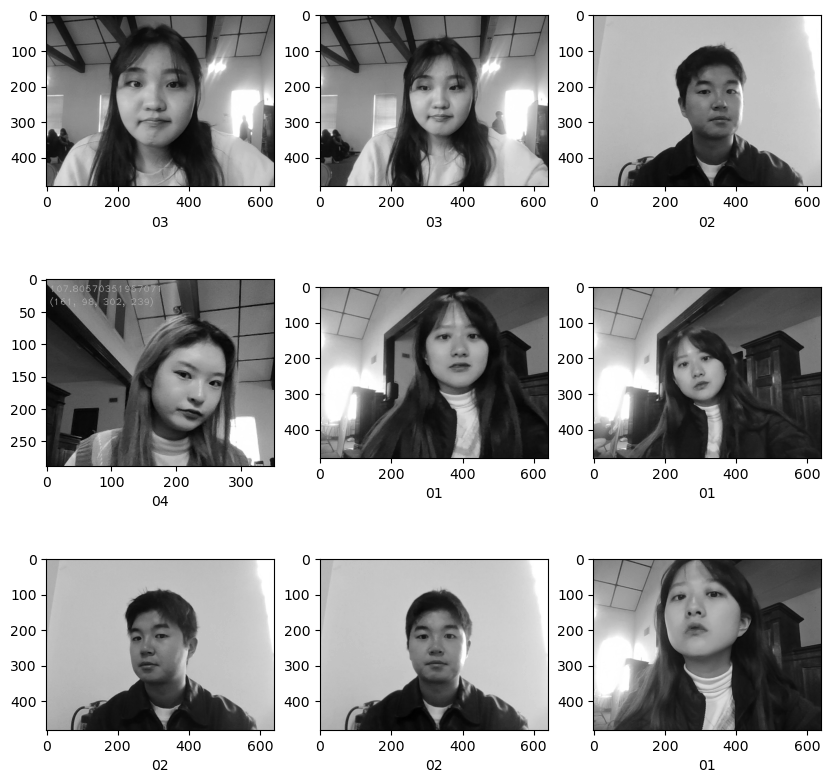

In [5]:
# Check image dataset randomly
fig = plt.figure(figsize=(10,10))

for i in range(1,10):
    index = random.randint(0,len(grays)-1)
    plt.subplot(3,3,i)
    plt.imshow(grays[index], cmap="gray")
    plt.xlabel(labels[index].split("set")[1])
plt.show()

## 2. Detect Faces

Detect a face with Haar Cascade Classifier provided by OpenCV as a default, so there is no need to download or re-train a classifier.  
If the Classifier detects two faces, this code manages it separately. 

In [6]:
# Import haar cascade classifier from cv2 
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

coords = []          # face coordinates 
twoface_cnt = 0      # if there are two faces detected, count it
twoface_coords = []  # coordinates of two faces 
twoface_img = []     # image of two faces

# Detect face coordinate location in image, i.e, detect face 
# 'detectMultiScale' is a general function that detects objects 
for gray in grays : 
    coordinate = face_cascade.detectMultiScale( 
        gray,             # input grayscale image 
        scaleFactor=1.3,  # imgae pyramid scale 
        minNeighbors=4,   # neighbor object minimum distance pixels 
        minSize=(40, 40)  # minimum size of detecting object 
    )
    # If there are two faces detected, process it separately
    if len(coordinate) == 2 : 
        twoface_cnt+=1
        twoface_coords.append(coordinate)
        twoface_img.append(gray)
    coords.append(coordinate)

print("total coordinates: ", len(coords))
print("the number of detected two face: ", twoface_cnt)

total coordinates:  1200
the number of detected two face:  26


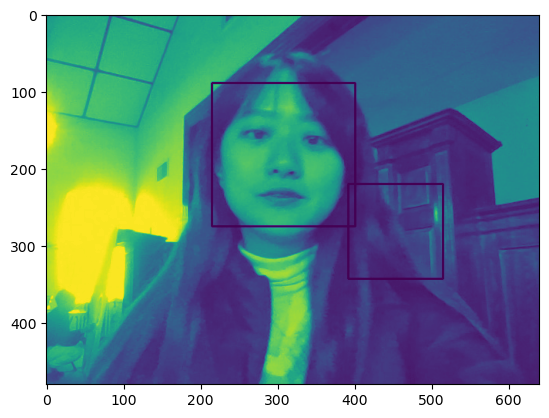

In [7]:
# Check the image of two faces detected 
x,y,w,h = twoface_coords[0][0]
x2,y2,w2,h2 = twoface_coords[0][1]
cv2.rectangle(twoface_img[0], (x, y), (x+w, y+h), (0, 255, 0), 2)
cv2.rectangle(twoface_img[0], (x2, y2), (x2+w2, y2+h2), (0, 255, 0), 2)
plt.imshow(twoface_img[0])

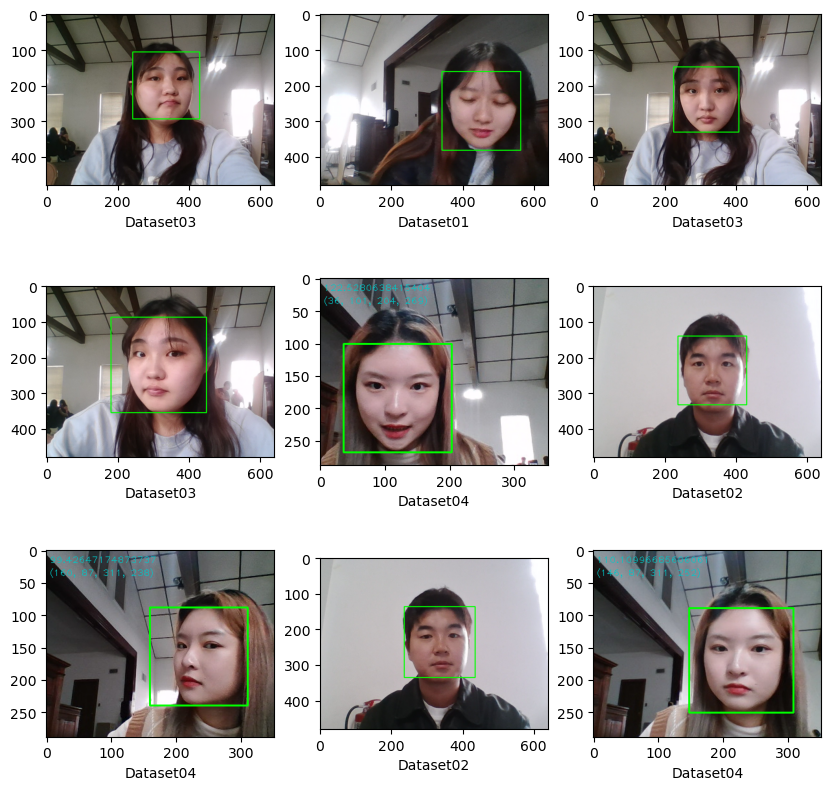

In [8]:
# Check the status of face detection on rgb color channel environment randomly
fig = plt.figure(figsize=(10,10))

for i in range(1,10):
    index = random.randint(0,len(coords)-1)
    plt.subplot(3,3,i)
    for (x,y,w,h) in coords[index] :
        cv2.rectangle(images[index], (x, y), (x+w, y+h), (0, 255, 0), 2)
    plt.imshow(images[index])
    plt.xlabel(labels[index])
plt.show()

## 3. Save Faces

Store the cropped face on the image using detected coordinates by Haar Cascade Classifier.  
In this step, the image size will be reduced because of computational amounts. 

In [11]:
# Configuration: set the image size for resizing
width = 50
height = 50

# Store cropped faces from the image
empty_idx = [] # indexes of detection failure
faces = []     # faces on the image 

for i in range (0, len(coords)) : 
    # If the face was not detected, 
    if len(coords[i]) == 0 : 
        empty_idx.append(i)
    else : 
        # If faces were detected (two more), 
        if len(coords[i]) == 2 :
            x1,y1,w,h = coords[i][1].squeeze()
        # If just one face was detected,
        else : 
            x1,y1,w,h = coords[i].squeeze()         
        x1, y1 = abs(x1), abs(y1)
        x2 = abs(x1+w)
        y2 = abs(y1+h)
        # Crop the loaction of the face in the image using the detected coordinates
        face = grays[i][y1:y2, x1:x2]
        # Resize for reducing computational amounts
        face = cv2.resize(face, (width, height))
        faces.append(face)
# Remove failed detection from labels
labels = np.delete(labels, empty_idx)

print("the number of failed face detection: ", len(empty_idx))
print("the number of successed face detection from labels: ", len(labels))
print("the number of successed face detection from faces: ", len(faces))   # the number of labels and faces should be same 

the number of failed face detection:  32
the number of successed face detection from labels:  1168
the number of successed face detection from faces:  1168


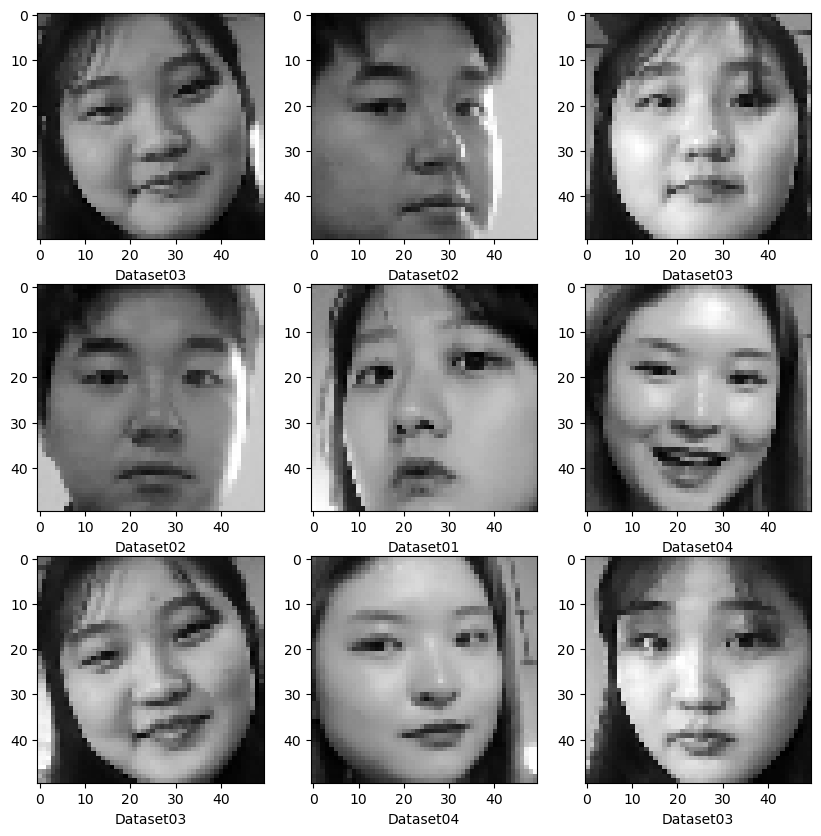

In [13]:
# Check the saved face randomly 
# Because of resizing, it seems like the image quality will be broken 
fig = plt.figure(figsize=(10,10))

for i in range(1,10):
    index = random.randint(0,len(faces)-1)
    plt.subplot(3,3,i)
    plt.imshow(faces[index], cmap="gray")
    plt.xlabel(labels[index])
plt.show()

## 3.1. Face Encoding 

This step is optional.  
If you use this step to create the face recognition model, it needs a lot of time to make encoding faces.  
Also, there are some delays when conducting the system in real-time with video camera. So it is recommended to skip this step. 

In [ ]:
# # Encode cropped faces 
# empty_idx = [] # indexes of detection failure
# encodings = [] # incoding faces

# for i, coordinate in enumerate(coords) : 
#     # If the face was not detected, 
#     if len(coords[i]) == 0 : 
#         empty_idx.append(i)
#     else : 
#         # If faces were detected (two more), 
#         if len(coords[i]) == 2 :
#             x1,y1,w,h = coords[i][1].squeeze()
#         # If just one face was detected,
#         else : 
#             x1,y1,w,h = coords[i].squeeze()  
#         # Encode the face with face_recognition provided by OpenCV
#         encoding = face_recognition.face_encodings(images[i], coordinate)
#         encodings.append(encoding)
# labels = np.delete(labels, empty_idx)

# print("the number of failed face detection: ", len(empty_idx))
# print("the number of successed face detection from labels: ", len(labels))
# print("the number of successed face detection from faces: ", len(encodings))  # the number of labels and encoding faces should be same 

## 4. Prepare Input Data

Reshape and split dataset for training and testing. 

In [14]:
# Transfering 3d array faces to dataframe for training PCA 
faces_3darray = [face for face in faces]
faces_2darray = [face.flatten().astype('int') for face in faces_3darray]
faces_df = pd.DataFrame(faces_2darray)
faces_df

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,149,148,77,36,28,28,26,25,28,27,...,12,11,10,11,11,14,16,18,25,25
1,21,19,20,18,18,21,21,21,21,23,...,18,17,13,11,11,21,19,15,15,17
2,93,33,26,24,24,22,22,22,24,26,...,10,9,10,12,12,17,18,24,26,27
3,149,150,145,55,28,24,23,22,23,22,...,11,11,13,13,11,11,9,11,13,15
4,152,155,101,41,27,23,20,21,20,26,...,11,11,13,13,14,12,10,10,10,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,149,149,152,144,130,135,108,99,77,56,...,44,29,17,18,23,25,31,51,78,105
1164,146,148,150,152,154,121,156,121,151,120,...,56,32,20,20,21,24,32,52,66,88
1165,148,147,146,144,142,140,166,167,154,116,...,26,25,35,24,15,15,18,21,25,46
1166,135,65,145,153,164,118,105,72,43,32,...,49,48,48,26,12,12,14,14,13,13


In [22]:
# Labeling y dataset 
le = LabelEncoder()
labels = le.fit_transform(labels)
print(le.classes_)
print(set(labels))

['Dataset01' 'Dataset02' 'Dataset03' 'Dataset04']
{0, 1, 2, 3}


In [23]:
# Split dataset as for training and testing 
X = faces_df 
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("the shape of train dataset: ", X_train.shape)
print("the shape of test dataset: ", X_test.shape)

the shape of train dataset:  (934, 2500)
the shape of test dataset:  (234, 2500)


## 5. PCA, Principal Component Analysis

Use PCA for dimension reduction.

In [24]:
# Configuration: set the size of PCA dimension 
n_components = 64
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)

# Transform dataset with PAC
X_train_pca = pca.transform(X_train) 
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape) 
print(X_test_pca.shape)
print(y_train.shape)
print(y_test.shape)

(934, 64)
(234, 64)
(934,)
(234,)


## 6. Train with SVM,  Support Vector Machine

Search the best parameters by GridSearchCV and train SVM with it. 

In [25]:
param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
          }

print("Fitting the classifier to the training set")
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', probability=True), param_grid)
svm = svm.fit(X_train_pca, y_train)

print("Best estimator found by grid search:")
print(svm.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0005, probability=True)


## 7. Evaluate

In [27]:
# Predict test dataset
predict = svm.predict(X_test_pca)

# Print evaluation report 
print(predict[:20])
print(y_test[:20], '\n')
print(classification_report(y_test, predict), '\n')
print("accuracy score: ", accuracy_score(y_test, predict))

[2 3 0 0 3 1 2 0 1 1 0 0 3 0 1 3 1 1 2 1]
[2 3 0 0 3 1 2 0 1 1 0 0 3 0 1 3 1 1 2 1] 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       1.00      1.00      1.00        69
           2       1.00      1.00      1.00        54
           3       0.98      1.00      0.99        57

    accuracy                           1.00       234
   macro avg       1.00      1.00      1.00       234
weighted avg       1.00      1.00      1.00       234
 

accuracy score:  0.9957264957264957


## 8. Export model

In [ ]:
import pickle

# Save the SVM to disk
filename = 'svm.sav' # config 
pickle.dump(svm, open(path+filename, 'wb')) 

# Save the PCA to disk 
filename = 'pca.pkl' # config
pickle.dump(pca, open(path+filename, "wb"))

In [ ]:
# Load the saved pca from disk 
pca_reload = pickle.load(open(path+filename,'rb'))
result_pca = pca_reload .transform(X_train)
print(result_pca[:3])
print(X_train_pca[:3])

# Load the saved model from disk
svm_reload = pickle.load(open(path+filename, 'rb'))
result_svm = loaded_model.score(X_test_pca, y_test)
print(result_svm)